# chemtools

> A collection of tools to perform cheminformatics tasks.

## How to use

Chemtools offer a collection of cheminformatics scripts for daily tasks. Currently supported tasks include:

    1 - Standardization of chemical structures

    2 - Calculation of molecular descriptors
    
    3 - Filtering datasets using predefined alerts (e.g. PAINS, Dundee, Glaxo)

# Standardization

A dataset of molecules can be standardize in just 1 line of code!

In [ ]:
#|hide
import pandas as pd
import numpy as np
from chemtools.tools.sanitizer import MolCleaner
from chemtools.tools.featurizer import MolFeaturizer
from chemtools.tools.filtering import MolFiltering
from rdkit import Chem

In [ ]:
data = pd.read_csv('../data/Lipophilicity.csv')

# Sanitizing

The [`MolCleaner`]('sanitizer.ipynb') class performs sanitization tasks following the steps implemented on [chembl_structure_pipeline](https://github.com/chembl/ChEMBL_Structure_Pipeline)
        
        1. Standardize unknown stereochemistry (Handled by the RDKit Mol file parser)
            i) Fix wiggly bonds on sp3 carbons - sets atoms and bonds marked as unknown stereo to no stereo
            ii) Fix wiggly bonds on double bonds – set double bond to crossed bond
        2. Clears S Group data from the mol file
        3. Kekulize the structure
        4. Remove H atoms (See the page on explicit Hs for more details)
        5. Normalization:
            Fix hypervalent nitro groups
            Fix KO to K+ O- and NaO to Na+ O- (Also add Li+ to this)
            Correct amides with N=COH
            Standardise sulphoxides to charge separated form
            Standardize diazonium N (atom :2 here: [*:1]-[N;X2:2]#[N;X1:3]>>[*:1]) to N+
            Ensure quaternary N is charged
            Ensure trivalent O ([*:1]=[O;X2;v3;+0:2]-[#6:3]) is charged
            Ensure trivalent S ([O:1]=[S;D2;+0:2]-[#6:3]) is charged
            Ensure halogen with no neighbors ([F,Cl,Br,I;X0;+0:1]) is charged
        6. The molecule is neutralized, if possible. See the page on neutralization rules for more details.
        7. Remove stereo from tartrate to simplify salt matching
        8. Normalise (straighten) triple bonds and allenes
        
        
        
        The curation steps in ChEMBL structure pipeline were augmented with additional steps to identify duplicated entries
        9. Find stereo centers
        10. Generate inchi keys
        11. Find duplicated SMILES. If the same SMILES is present multiple times, two outcomes are possible.
            i. The same compound (e.g. same ID and same SMILES)
            ii. Isomers with different SMILES, IDs and/or activities
            
            In case i), the compounds are merged by taking the median values of all numeric columns in the dataframe. 
            For case ii), the compounds are further classified as 'to merge' or 'to keep' depending on the activity values.
                a) Compounds are considered for mergining (to merge) if the difference in acvitities is less than 1log unit.
                b) Compounds are considered for keeping as individual entries (to keep) if the difference in activities is larger than 1log unit. In this case, the user can
                select which compound to keep - the one with highest or lowest activity.

In [ ]:
processed_data = MolCleaner.from_df(data, smiles_col='smiles', act_col='exp', id_col='CMPD_CHEMBLID')

100%|██████████| 1000/1000 [00:03<00:00, 265.25it/s]


# Filtering

The [`MolFiltering`]('filtering.ipynb') class is responsible for removing compounds that match defined substructural alerts, including PAINS and rules defined by different organizations, such as GSK and University of Dundee. 

In [ ]:
clean_dataset, alerts_dataset = MolFiltering.from_df(processed_data, smiles_col='processed_smiles')

100%|██████████| 1000/1000 [00:19<00:00, 52.32it/s]


Total number of flagged molecules = 17
Most common flag = I13 Cyanamides


In [ ]:
alerts_dataset.set_index('processed_smiles')['Alert_rule_set']

processed_smiles
Nc1nc(OC2CCCC2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@H](Cl)[C@H]1O                         Glaxo
CS(=O)(=O)c1ccc(N2CCN(C(=O)[C@@H]3CCCC[C@H]3C(=O)NCC#N)CC2)cc1                    Glaxo
Cn1cc(-c2cccc(C[C@H](NC(=O)c3cc(C(C)(C)C)nn3C)C(=O)NCC#N)c2)cn1                   Glaxo
CC(C)c1ccccc1Cc1cc(C(=O)Nc2ccc(S(=O)(=O)c3ccccc3C(C)(C)C)cc2)c(O)c(O)c1O          Glaxo
Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)NCC#N)c1                             Glaxo
C[C@H]1O[C@@H](n2cnc3c(N)nc(OCC4CC45CC5)nc32)[C@H](O)[C@H]1Cl                     Glaxo
CC(=O)c1ncccc1NC(=O)[C@H]1CC[C@H](N2C(=O)[C@H]3[C@H]4CC[C@H](C4)[C@H]3C2=O)CC1    Glaxo
C[S+]([O-])CCN1C(=O)C(NC(=O)c2cc3cc(Cl)sc3[nH]2)Cc2ccccc21                        Glaxo
C=CCCCCCCCCC(=O)N[C@H]1CCC(=O)NC1=O                                               Glaxo
C=CCCCCCCCCC(=O)N[C@H]1CCC(=O)NC1=O                                               Glaxo
O=c1c(O)cccc2cc(O)c(O)c(O)c12                                                     Glaxo
CCCN1CCN(c2ccc(

#### Quinone

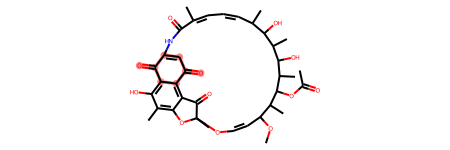

In [ ]:
mol = Chem.MolFromSmiles('COC1/C=C\OC2(C)Oc3c(C)c(O)c4c(c3C2=O)C(=O)C=C(NC(=O)/C(C)=C\C=C/C(C)C(O)C(C)C(O)C(C)C(OC(C)=O)C1C)C4=O')
mol.GetSubstructMatches(Chem.MolFromSmarts('O=C1[#6]~[#6]C(=O)[#6]~[#6]1'))
mol

#### Cynamide

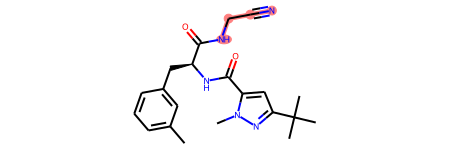

In [ ]:

mol1 = Chem.MolFromSmiles('Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)NCC#N)c1')
mol1.GetSubstructMatches(Chem.MolFromSmarts('N[CH2]C#N'))
mol1

#### R18 Quaternary C, Cl, I, P or S

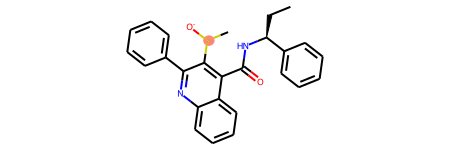

In [ ]:

mol = Chem.MolFromSmiles('CC[C@H](NC(=O)c1c([S+](C)[O-])c(-c2ccccc2)nc2ccccc12)c1ccccc1')
mol.GetSubstructMatches(Chem.MolFromSmarts('[C+,Cl+,I+,P+,S+]'))
mol

# Featurization

The [`MolFeaturizer`]('featurizer.ipynb') class converts SMILES into molecular descriptors. The current version supports Morgan fingerprints, Atom Pairs, Torsion Fingerprints, RDKit fingerprints and 200 constitutional descriptors, and MACCS keys.

In [ ]:
fingerprinter = MolFeaturizer('morgan')

In [ ]:
X = fingerprinter.process_smiles_list(clean_dataset['processed_smiles'].values)

In [ ]:
X[0:5]